In [1]:
import math
import keras
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn import preprocessing

Using TensorFlow backend.


### Leitura dos dados

In [3]:
df = pd.read_csv("./../winequality.csv", sep=";")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Vejamos os tipos de dados de cada coluna

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


### TRATAMENTO DO BANCO DE DADOS

Se observado os dados type e alcohol são objects, precisamos só trabalhar com números.

* type: object (vamos mudar para inteiro)
* alcohol: object (vamos mudar para float e eliminar dados incosistentes)

In [5]:
#adicionar números como representantes das categorias
df['type'] = df['type'].map( {'White': 1, 'Red': 0} ).astype(int)
#vamos corrigir os erros da coluna, e substituí-los para NaN, em seguida preencher essas lacunas com a moda
#poderiamos ignorá-los, mas cada dado é valioso e vamos investigar usando essas dados corrompidos
df['alcohol'] = pd.to_numeric(df['alcohol'], errors='coerce')
freq_port = df.alcohol.dropna().mode()[0]
df['alcohol'] = df['alcohol'].fillna(freq_port)

### Agora os dados são apenas números!!!

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [7]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,1,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,0,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Para começar a análise, vamos ver como a distribuição dos dados se dá

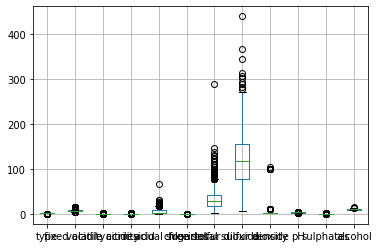

In [8]:
df.boxplot(column=list(df.columns[:-1]))

### Percebe-se que alguns atributos tem valores discrepantes, para melhorar essa visualização e não enviesar nossos modelos (alguns podem ser enviesados por essa discrepâcia de valores).